
#  Fish Classification - Colab Training Notebook



### 1. Data Preprocessing and Augmentation ###

In [2]:
#Install Required Libraries
!pip install tensorflow pillow

In [4]:
from google.colab import files
import zipfile
import os

# Step 1: Upload ZIP file
uploaded = files.upload()

# Step 2: Get actual uploaded file name
uploaded_filename = list(uploaded.keys())[0]

# Step 3: Create full path
zip_path = os.path.join("/content", uploaded_filename)

# Step 4: Extract it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print(f"Successfully extracted {uploaded_filename} to /content/data")

Saving Dataset.zip to Dataset (1).zip
✅ Successfully extracted Dataset (1).zip to /content/data


In [5]:
#Import required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Directory Paths
train_dir = "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/train"
val_dir = "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/val"
test_dir = "/content/data/images.cv_jzk6llhf18tm3k0kyttxz/data/test"

# Set Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # rotate image up to 20 degrees
    zoom_range=0.2,              # zoom in/out by 20%
    width_shift_range=0.2,       # shift image left/right
    height_shift_range=0.2,      # shift image up/down
    horizontal_flip=True,        # flip image horizontally
    fill_mode='nearest'          # fill empty pixels after rotation/shift
)

# No Augmentation for Validation/Test, only Rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'  # for multiclass classification
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False   # important for evaluation
)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


## 2. Model Training

In [6]:
#1. CNN Model from Scratch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input

model_scratch = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax') # 11 classes
])

model_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
#2. Pretrained Transfer Learning Models
#Common Function to Load and Fine-tune Models
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, NASNetMobile, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

def build_model(base_model_class, input_shape=(224, 224, 3), num_classes=11):
    base_model = base_model_class(include_top=False, input_tensor=Input(shape=input_shape), weights='imagenet')
    base_model.trainable = False  # Freeze initial layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
#Build Models
vgg_model = build_model(VGG16)
resnet_model = build_model(ResNet50)
mobilenet_model = build_model(MobileNetV2)
nasnetmobile_model = build_model(NASNetMobile)
efficientnet_model = build_model(EfficientNetB0, input_shape=(224, 224, 3))  # Explicit input shape

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipython-input-7-4071984145.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = base_model_class(include_top=False, input_tensor=Input(shape=input_shape), weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
#3. Model Training + Saving Best Model
#1. VGG16 Model Training
from tensorflow.keras.callbacks import EarlyStopping
vgg_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

vgg_history = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[vgg_early_stop]
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 94s 483ms/step - accuracy: 0.8072 - loss: 0.6292 - val_accuracy: 0.9029 - val_loss: 0.4120
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 460ms/step - accuracy: 0.8277 - loss: 0.5765 - val_accuracy: 0.8984 - val_loss: 0.3858
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 455ms/step - accuracy: 0.8432 - loss: 0.5207 - val_accuracy: 0.9194 - val_loss: 0.3233
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 461ms/step - accuracy: 0.8539 - loss: 0.4732 - val_accuracy: 0.9267 - val_loss: 0.3032
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 94s 482ms/step - accuracy: 0.8496 - loss: 0.4666 - val_accuracy: 0.9341 - val_loss: 0.2615
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 95s 485ms/step - accuracy: 0.8698 - loss: 0.4093 - val_accuracy: 0.9396 - val_loss: 0.2453
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 142s 487ms/step - accuracy: 0.8812 - loss: 0.3789 - val_accuracy: 0.9386 - val_loss: 0.2487
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 456ms/step - accuracy: 0.8777 - loss: 

In [11]:
#2. ResNet50 Model Training
resnet_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[resnet_early_stop]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_34']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


195/195 ━━━━━━━━━━━━━━━━━━━━ 106s 474ms/step - accuracy: 0.1517 - loss: 2.4151 - val_accuracy: 0.1712 - val_loss: 2.2786
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 416ms/step - accuracy: 0.1762 - loss: 2.2896 - val_accuracy: 0.1712 - val_loss: 2.2256
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.1754 - loss: 2.2559 - val_accuracy: 0.1712 - val_loss: 2.2078
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 408ms/step - accuracy: 0.1738 - loss: 2.2308 - val_accuracy: 0.1712 - val_loss: 2.1639
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 418ms/step - accuracy: 0.1738 - loss: 2.1986 - val_accuracy: 0.1832 - val_loss: 2.1412
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - accuracy: 0.1906 - loss: 2.1776 - val_accuracy: 0.1731 - val_loss: 2.1155
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 409ms/step - accuracy: 0.1878 - loss: 2.1560 - val_accuracy: 0.2042 - val_loss: 2.0877
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 414ms/step - accuracy: 0.1969 - loss: 2.1419 - va

In [12]:
#3. MobileNet Model Training
mobilenet_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[mobilenet_early_stop]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_213']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


195/195 ━━━━━━━━━━━━━━━━━━━━ 94s 430ms/step - accuracy: 0.5929 - loss: 1.2560 - val_accuracy: 0.9515 - val_loss: 0.1824
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 388ms/step - accuracy: 0.9064 - loss: 0.3006 - val_accuracy: 0.9579 - val_loss: 0.1047
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 390ms/step - accuracy: 0.9300 - loss: 0.2149 - val_accuracy: 0.9670 - val_loss: 0.0856
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 74s 382ms/step - accuracy: 0.9514 - loss: 0.1569 - val_accuracy: 0.9808 - val_loss: 0.0587
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 387ms/step - accuracy: 0.9569 - loss: 0.1406 - val_accuracy: 0.9835 - val_loss: 0.0495
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.9635 - loss: 0.1098 - val_accuracy: 0.9817 - val_loss: 0.0542
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 391ms/step - accuracy: 0.9633 - loss: 0.1119 - val_accuracy: 0.9844 - val_loss: 0.0450
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 385ms/step - accuracy: 0.9626 - loss: 0.1079 - val

In [13]:
#4. NASNetMobile Model Training
from tensorflow.keras.callbacks import EarlyStopping
nasnet_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

nasnet_history = nasnetmobile_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[nasnet_early_stop]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_371']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


195/195 ━━━━━━━━━━━━━━━━━━━━ 144s 567ms/step - accuracy: 0.5324 - loss: 1.4026 - val_accuracy: 0.8901 - val_loss: 0.3938
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 405ms/step - accuracy: 0.8297 - loss: 0.5127 - val_accuracy: 0.9231 - val_loss: 0.2602
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 403ms/step - accuracy: 0.8685 - loss: 0.3796 - val_accuracy: 0.9396 - val_loss: 0.1894
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 404ms/step - accuracy: 0.8947 - loss: 0.3095 - val_accuracy: 0.9469 - val_loss: 0.1718
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 418ms/step - accuracy: 0.9081 - loss: 0.2577 - val_accuracy: 0.9405 - val_loss: 0.1758
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 405ms/step - accuracy: 0.9172 - loss: 0.2346 - val_accuracy: 0.9505 - val_loss: 0.1514
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 404ms/step - accuracy: 0.9271 - loss: 0.2176 - val_accuracy: 0.9478 - val_loss: 0.1517
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 408ms/step - accuracy: 0.9285 - loss: 0.2204 - va

In [14]:
#5. EfficientNetB0 Model Training
efficientnet_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

efficientnet_history = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[efficientnet_early_stop]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1144']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


195/195 ━━━━━━━━━━━━━━━━━━━━ 116s 486ms/step - accuracy: 0.1311 - loss: 2.3760 - val_accuracy: 0.1712 - val_loss: 2.3164
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 112s 384ms/step - accuracy: 0.1783 - loss: 2.3198 - val_accuracy: 0.1712 - val_loss: 2.3107
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 74s 381ms/step - accuracy: 0.1683 - loss: 2.3164 - val_accuracy: 0.1712 - val_loss: 2.3147
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 392ms/step - accuracy: 0.1706 - loss: 2.3110 - val_accuracy: 0.1712 - val_loss: 2.3107
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 385ms/step - accuracy: 0.1861 - loss: 2.3066 - val_accuracy: 0.1712 - val_loss: 2.3102
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 390ms/step - accuracy: 0.1820 - loss: 2.3025 - val_accuracy: 0.1712 - val_loss: 2.3116


In [15]:
#After training all models, compare their validation accuracies
vgg_val_acc = max(vgg_history.history['val_accuracy'])
resnet_val_acc = max(resnet_history.history['val_accuracy'])
mobilenet_val_acc = max(mobilenet_history.history['val_accuracy'])
nasnet_val_acc = max(nasnet_history.history['val_accuracy'])
efficientnet_val_acc = max(efficientnet_history.history['val_accuracy'])

In [19]:
# Dictionary mapping model names to model objects
model_dict = {
    "VGG16": vgg_model,
    "ResNet50": resnet_model,
    "MobileNetV2": mobilenet_model,
    "EfficientNetB0": efficientnet_model,
    "NASNetMobile": nasnetmobile_model  # if used
}

# Get the best model object from the name
best_model = model_dict[best_model_name]

# Save the best model
best_model.save("best_fish_model.h5")

print(f"Saved best model: {best_model_name} with accuracy {accuracies[best_model_name]:.4f}")


Saved best model: MobileNetV2 with accuracy 0.9927


## 3. Model Evaluation and Visualization

In [20]:
# Install all required dependencies
!pip install seaborn scikit-learn matplotlib

In [21]:
#1.Evaluate Each Model on the Test Set
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate function
def evaluate_model(model, model_name):
    print(f" Evaluating {model_name}...")

    # Get predictions
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    # True labels
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

🔍 Evaluating VGG16...
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step

📊 Classification Report for VGG16:

                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.96      1.00      0.98       298
   fish sea_food gilt_head_bream       0.99      0.97      0.98       305
   fish sea_food hourse_mackerel       0.98      0.98      0.98       286
        fish sea_food red_mullet       0.97      0.94      0.96       291
     fish sea_food red_sea_bream       0.98      0.99      0.99       273
          fish sea_food sea_bass       1.00      0.97      0.98       327
            fish sea_food shrimp       0.97      1.00      0.99       289
fish sea_food striped_red_mullet       0.94      0.95      0.94       293
             fish sea_food trout       1.00      1.00      1.00       292

       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


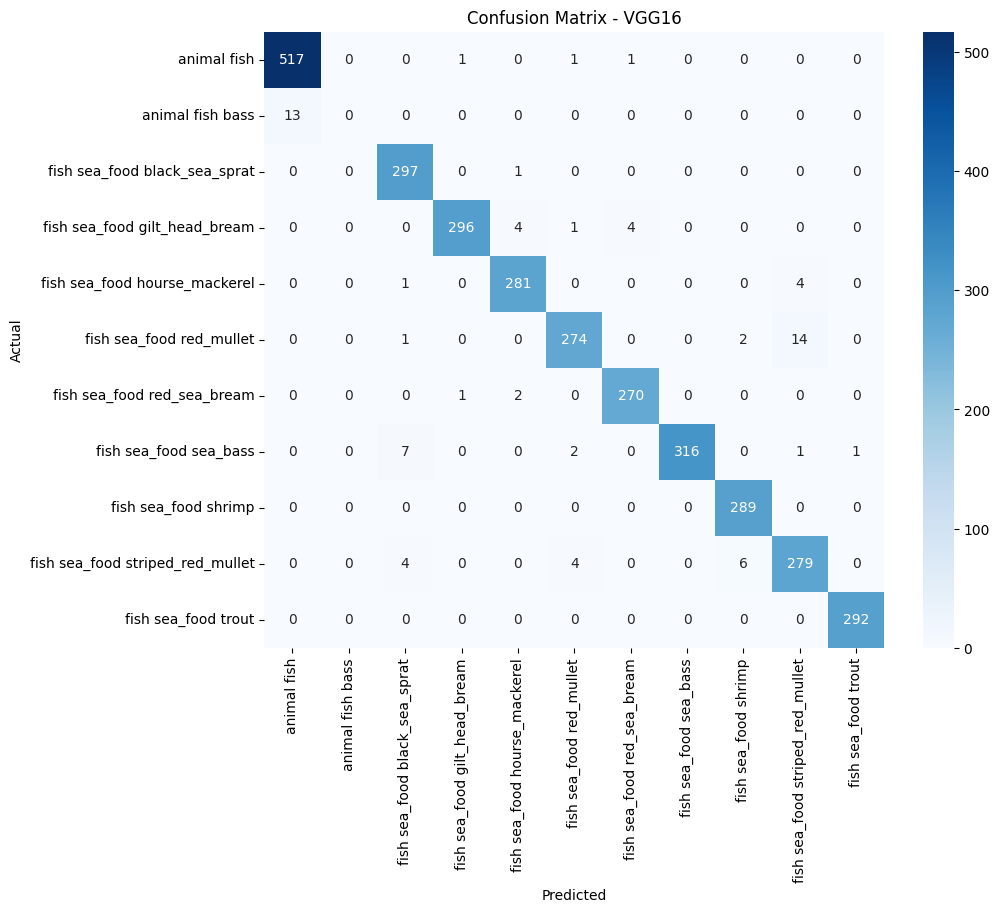

In [29]:
#Run this for each model:
evaluate_model(vgg_model, "VGG16")

🔍 Evaluating ResNet50...
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step

📊 Classification Report for ResNet50:

                                  precision    recall  f1-score   support

                     animal fish       0.34      0.68      0.45       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.25      0.67      0.37       286
        fish sea_food red_mullet       0.34      0.21      0.26       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.22      0.67      0.33       289
fish sea_food striped_red_mullet       0.15      0.07      0.10       293
             fish sea_food trout       0.25      0.16      0.20       292

   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


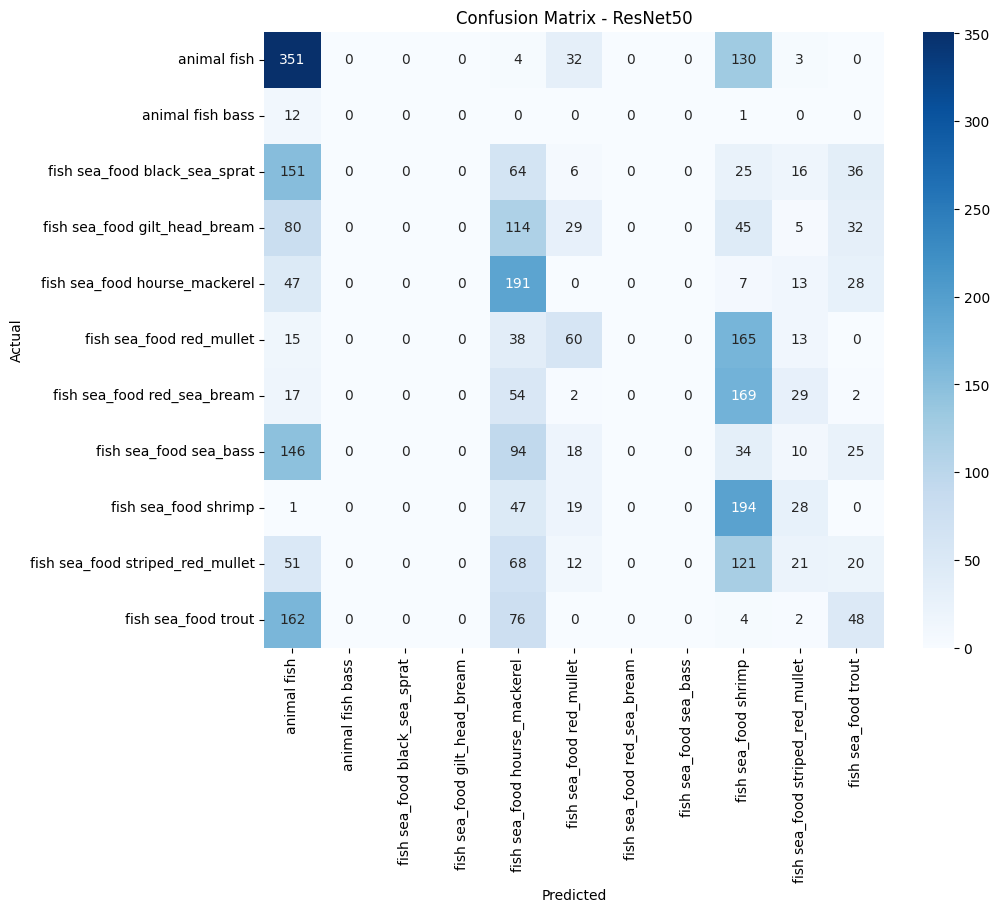

In [30]:
evaluate_model(resnet_model, "ResNet50")

🔍 Evaluating MobileNetV2...
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step

📊 Classification Report for MobileNetV2:

                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      0.99       520
                animal fish bass       1.00      0.54      0.70        13
   fish sea_food black_sea_sprat       1.00      0.97      0.99       298
   fish sea_food gilt_head_bream       1.00      0.99      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      0.99      1.00       291
     fish sea_food red_sea_bream       0.99      1.00      1.00       273
          fish sea_food sea_bass       0.98      1.00      0.99       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.98      1.00      0.99       293
             fish sea_food trout       1.00      1.00      1.00       29

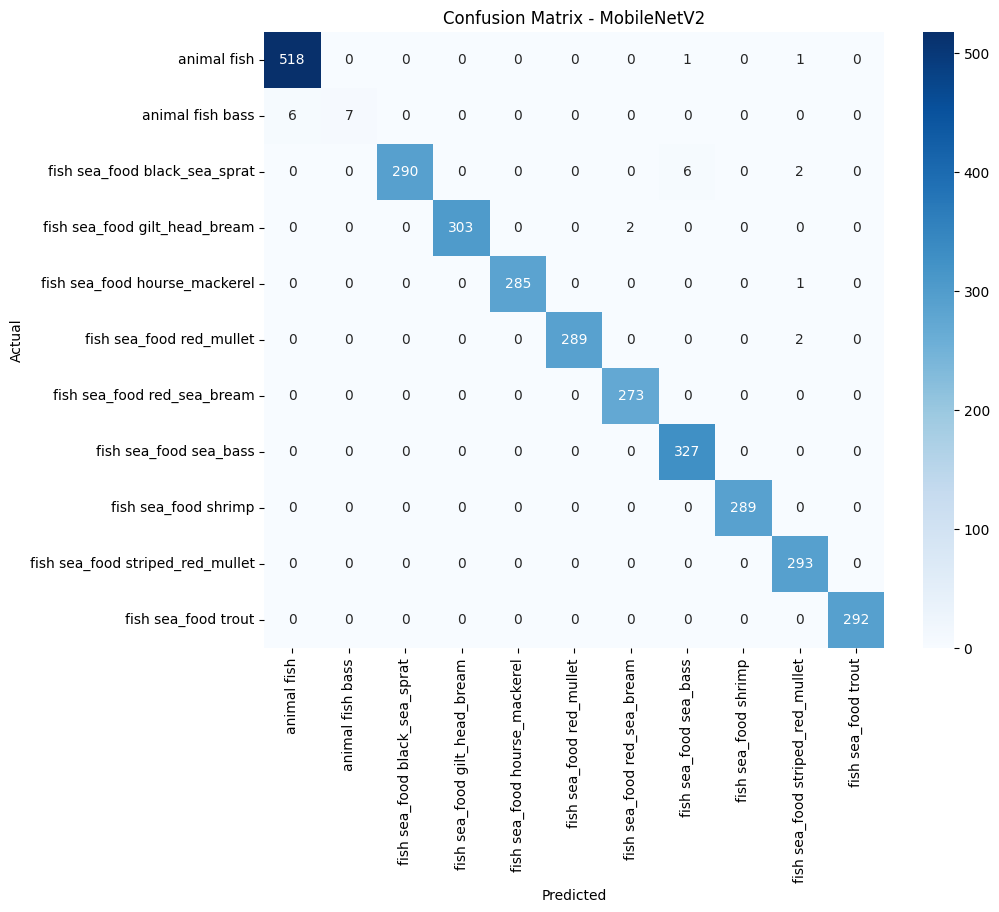

In [31]:
evaluate_model(mobilenet_model, "MobileNetV2")

🔍 Evaluating NASNetMobile...
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step

📊 Classification Report for NASNetMobile:

                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.99       520
                animal fish bass       1.00      0.23      0.38        13
   fish sea_food black_sea_sprat       0.99      0.97      0.98       298
   fish sea_food gilt_head_bream       0.97      1.00      0.98       305
   fish sea_food hourse_mackerel       0.95      1.00      0.97       286
        fish sea_food red_mullet       0.98      0.96      0.97       291
     fish sea_food red_sea_bream       1.00      0.98      0.99       273
          fish sea_food sea_bass       0.96      0.98      0.97       327
            fish sea_food shrimp       0.99      1.00      0.99       289
fish sea_food striped_red_mullet       0.96      0.91      0.93       293
             fish sea_food trout       0.99      0.98      0.99       

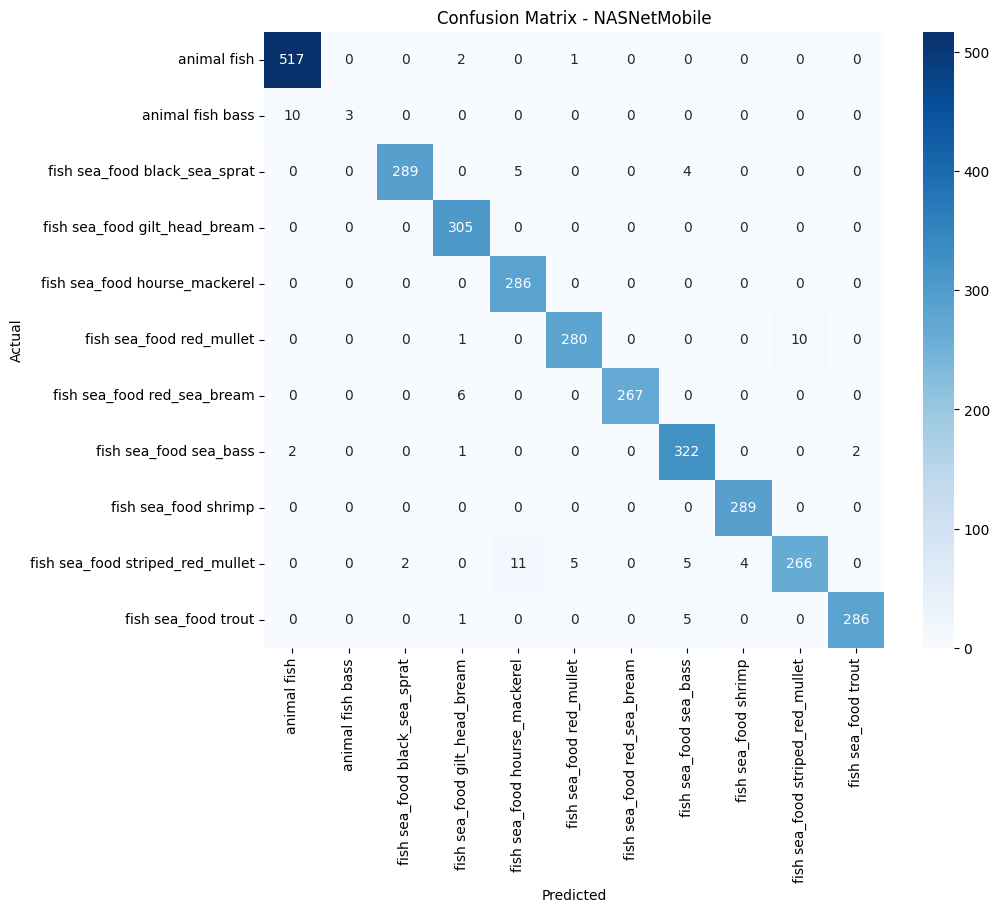

In [32]:
evaluate_model(nasnetmobile_model, "NASNetMobile")

🔍 Evaluating EfficientNetB0...
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step

📊 Classification Report for EfficientNetB0:

                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


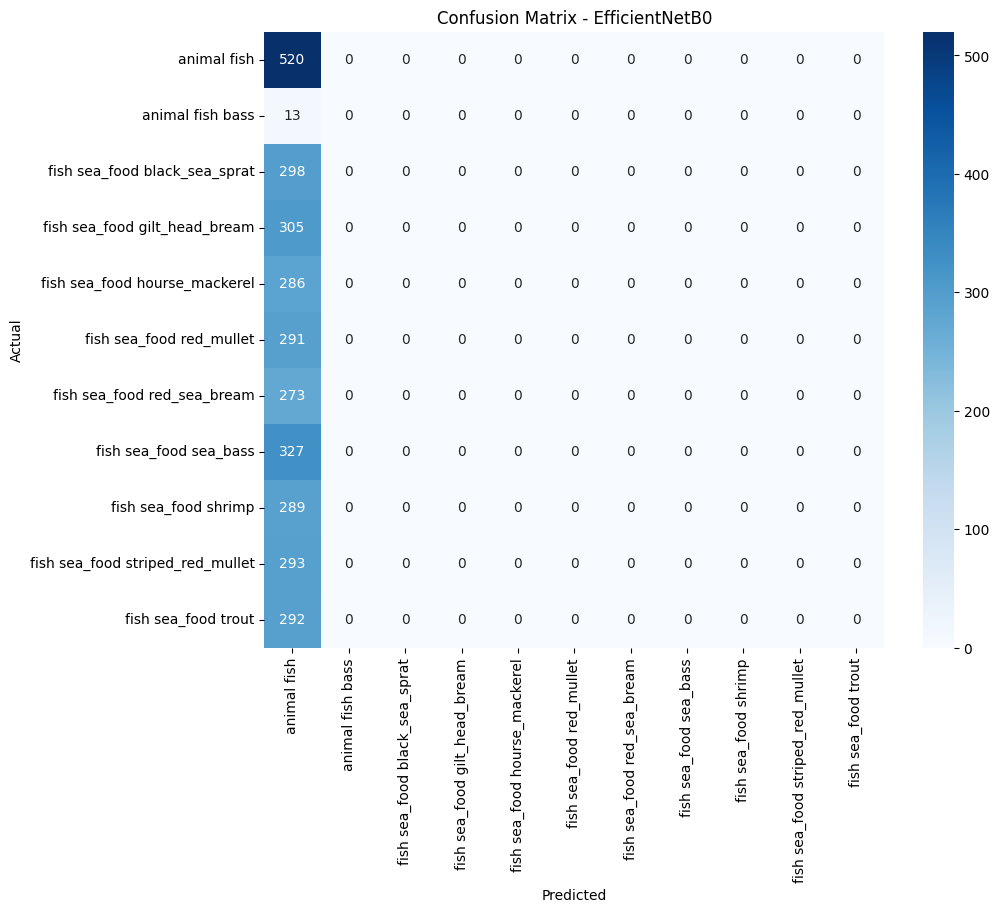

In [33]:
evaluate_model(efficientnet_model, "EfficientNetB0")

In [23]:
#2.Visualize Accuracy and Loss (Training History)
def plot_history(history, model_name):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

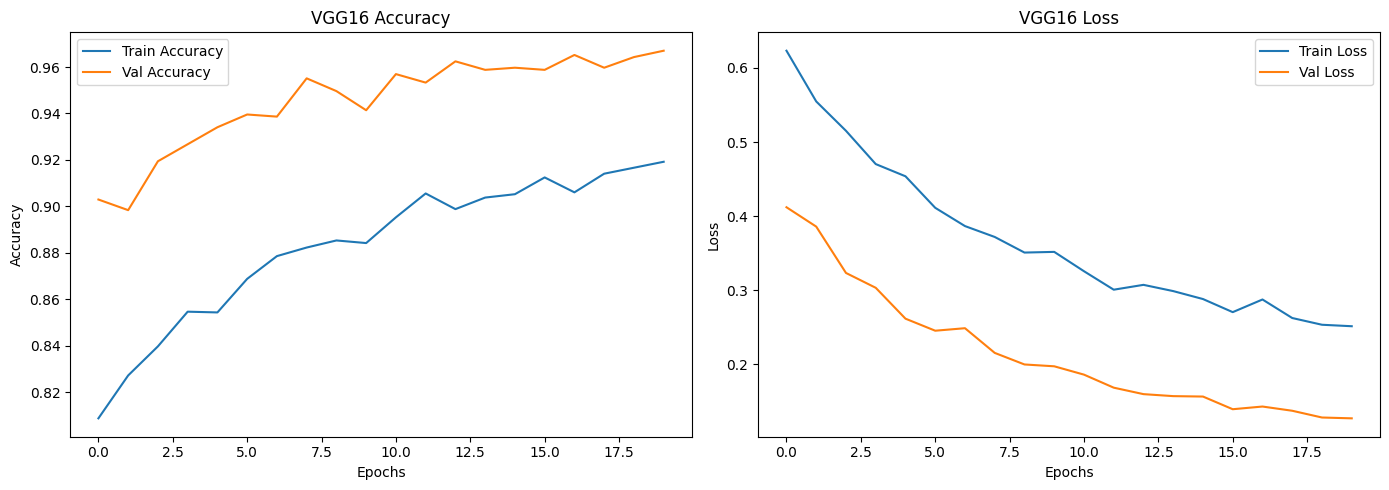

In [24]:
#Run this for each training history:
plot_history(vgg_history, "VGG16")

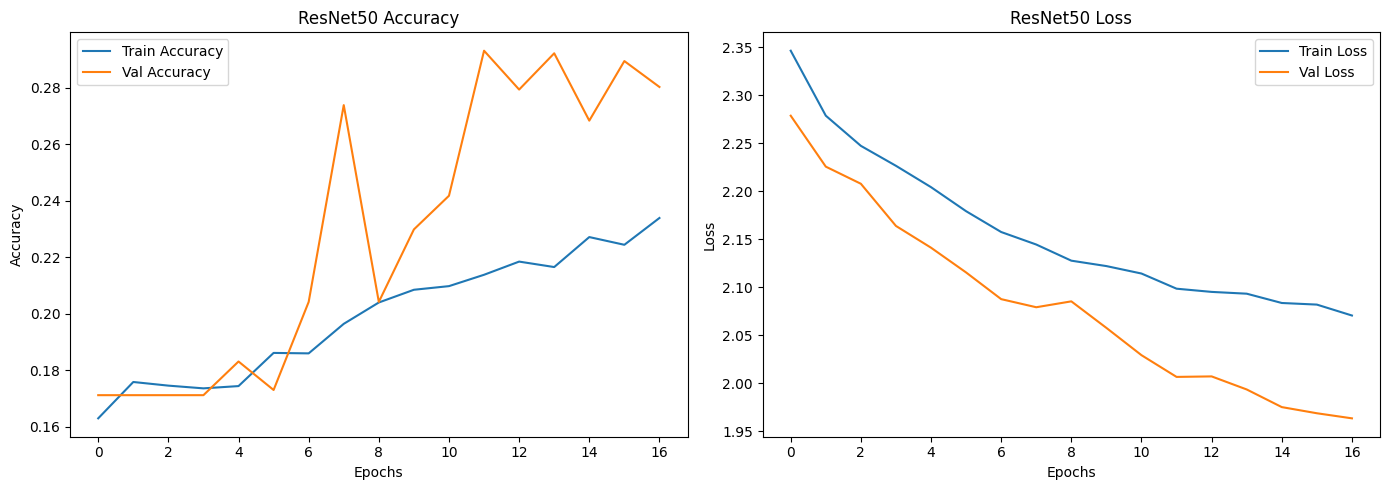

In [25]:
plot_history(resnet_history, "ResNet50")

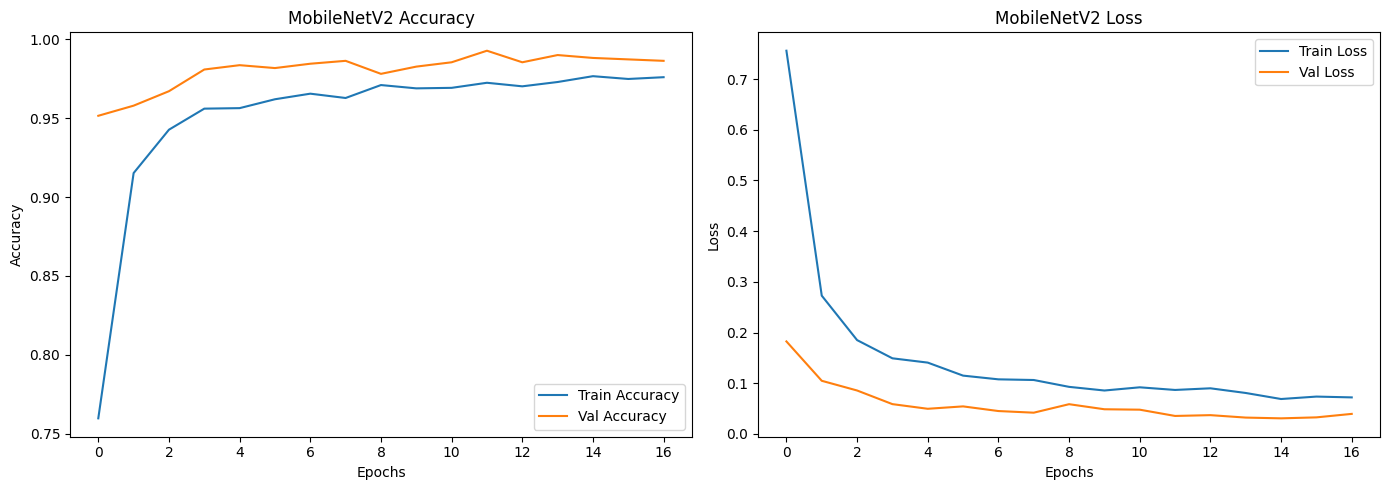

In [26]:
plot_history(mobilenet_history, "MobileNetV2")

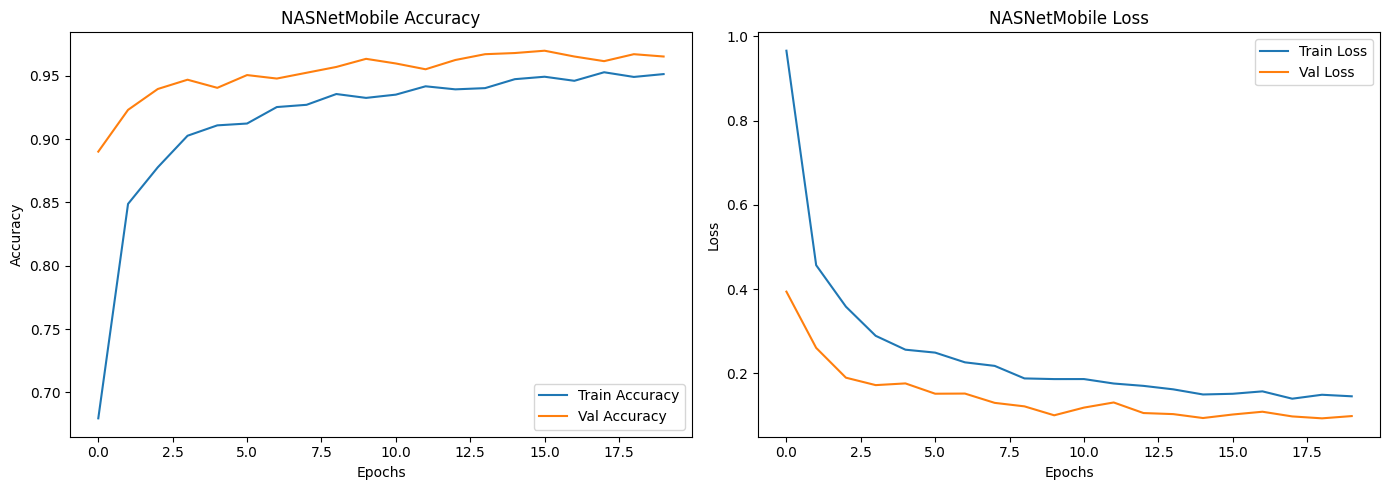

In [27]:
plot_history(nasnet_history, "NASNetMobile")

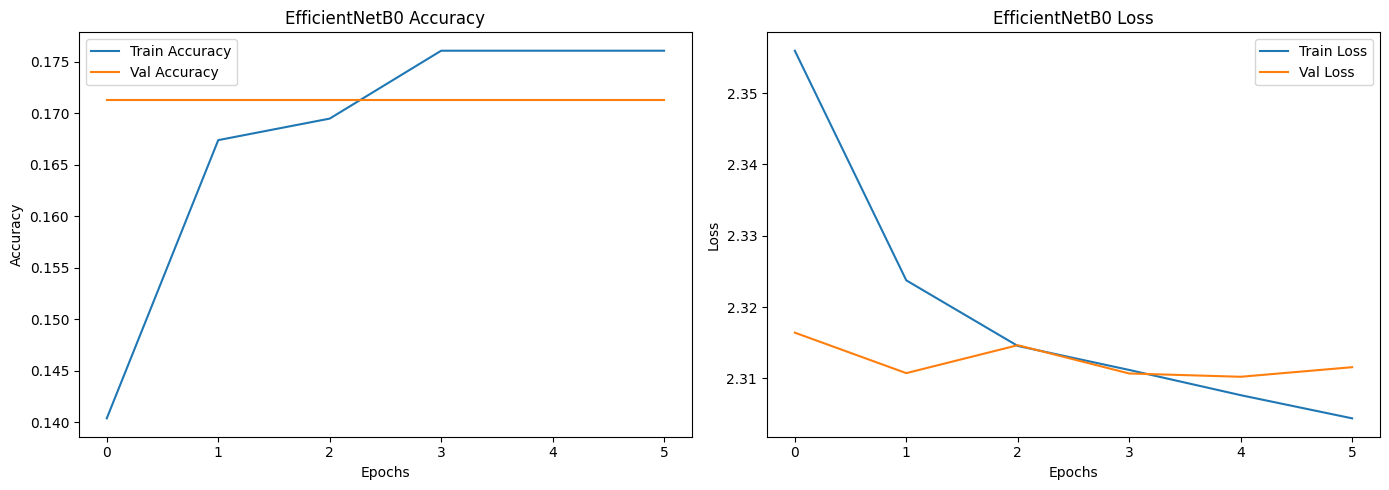

In [28]:
plot_history(efficientnet_history, "EfficientNetB0")